## Topic Modeling with Term Frequency-Inverse Document Frequency
### 1. Corpus Creation

In [1]:
# retrieve data from Preprocessing
%store -r data_lemmatized df

from gensim import corpora, models
from pprint import pprint
import gensim

# Create Dictionary
id2word = gensim.corpora.Dictionary(data_lemmatized)

# Filtering out of tokens appearing in less than 20 documents or more than 70% of documents
id2word.filter_extremes(no_below=20, no_above=0.7)

# Create Corpus
bow_corpus = [id2word.doc2bow(doc) for doc in data_lemmatized]

# Create the TF-IDF model based on the bag-of-words corpus
tfidf_model = models.TfidfModel(bow_corpus)

# Apply the TF-IDF transformation to the corpus
tfidf_corpus = tfidf_model[bow_corpus]

for doc in tfidf_corpus:
    pprint(doc)
    break

[(0, 0.17690613756060086),
 (1, 0.13205008895998877),
 (2, 0.14336469175790142),
 (3, 0.14913808879720644),
 (4, 0.18731716171680116),
 (5, 0.19524770945331216),
 (6, 0.04689342344440567),
 (7, 0.26331130930551977),
 (8, 0.26416774953322836),
 (9, 0.19340339809371676),
 (10, 0.31448092903974306),
 (11, 0.3189738583094442),
 (12, 0.096278199935693),
 (13, 0.10405330187201527),
 (14, 0.17849338528617428),
 (15, 0.06802944545411793),
 (16, 0.043326972794528074),
 (17, 0.08654357014989379),
 (18, 0.3695068229344004),
 (19, 0.37115918582026985),
 (20, 0.11042566660647649),
 (21, 0.20566964840912783),
 (22, 0.13371304691656322),
 (23, 0.208036474980719)]


### 2. Default LDA model

In [2]:
# calculate lda model with default parameters & 10 topics
num_topics = 10
lda_model_tfidf = gensim.models.LdaMulticore(tfidf_corpus, 
                                             id2word=id2word, 
                                             num_topics=num_topics, 
                                             workers=3)

In [3]:
# show initial topics with top 10 assigned words
lda_model_tfidf.show_topics(10, num_words=10, formatted=False)

[(0,
  [('ride', 0.006344216),
   ('line', 0.0060002394),
   ('day', 0.0057364074),
   ('time', 0.005641206),
   ('great', 0.0056073917),
   ('park', 0.0056005036),
   ('disneyland', 0.005252452),
   ('get', 0.00489823),
   ('not', 0.004763595),
   ('place', 0.004556699)]),
 (1,
  [('great', 0.007819431),
   ('place', 0.0078072106),
   ('disneyland', 0.0064025233),
   ('time', 0.006334694),
   ('day', 0.0062596654),
   ('love', 0.0058241975),
   ('always', 0.005679696),
   ('park', 0.0055255606),
   ('fun', 0.0054084263),
   ('ride', 0.0052222535)]),
 (2,
  [('day', 0.0061991583),
   ('ride', 0.0060311817),
   ('park', 0.00575606),
   ('time', 0.0054421914),
   ('disney', 0.0053024665),
   ('disneyland', 0.0052203974),
   ('get', 0.0046265693),
   ('not', 0.0044571655),
   ('kid', 0.0044086045),
   ('great', 0.004255238)]),
 (3,
  [('ride', 0.0059778774),
   ('park', 0.005781455),
   ('disneyland', 0.005358748),
   ('disney', 0.0053242743),
   ('line', 0.005140175),
   ('time', 0.00513

#### Default coherence score

In [4]:
from gensim.models import CoherenceModel

# Compute Coherence Score with default alpha and beta values
coherence_model_lda_tfidf = CoherenceModel(model=lda_model_tfidf, 
                                           texts=data_lemmatized, 
                                           dictionary=id2word, 
                                           coherence='c_v')

coherence_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
print('Coherence Score: ', coherence_lda_tfidf)

Coherence Score:  0.31297319133380397


### 3. Compute model performance metrics

#### Calculation of coherence score with varying parameters

In [5]:
# Define function for calculation of coherence values
def compute_coherence_values_tfidf(corpus, dictionary, model):
    coherence_model_lda_tfidf = CoherenceModel(model=model, 
                                               texts=data_lemmatized, 
                                               dictionary=dictionary, 
                                               coherence='c_v')
    return coherence_model_lda_tfidf.get_coherence()

# Define function for training the model with different parameters
def train_lda_model(params, corpus, id2word):
    a, b, k = params
    lda_model_tfidf = gensim.models.LdaMulticore(corpus=corpus, 
                                                 id2word=id2word, 
                                                 num_topics=k, 
                                                 alpha=a,
                                                 eta=b)
    cv = compute_coherence_values_tfidf(corpus=corpus, 
                                        dictionary=id2word, 
                                        model=lda_model_tfidf)
    return cv

In [6]:
import itertools
import tqdm
from multiprocessing import Pool
from functools import partial
import multiprocess as mp

grid = {}
grid['Validation_Set'] = {}

# define range for alpha and beta values
alpha_list = ['symmetric', 0.01, 0.31, 0.61, 0.91]
beta_list = ['symmetric', 0.01, 0.31, 0.61, 0.91]

# create validation sets
num_of_docs = len(tfidf_corpus)
corpus_sets = [gensim.utils.ClippedCorpus(tfidf_corpus, int(num_of_docs * 0.75)), tfidf_corpus]
corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [], 'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence':[]}

# define function to run the lda models
def run_train_lda_model(corpus, id2word):
    # iterate through number of topics
    for k in range(2, 11):
        # iterate through alpha and beta values
        params = list(itertools.product(alpha_list, beta_list, [k]))
        partial_train_lda_model = partial(train_lda_model, corpus=corpus, id2word=id2word)
        with mp.Pool() as pool:
            results = pool.map(partial_train_lda_model, params)
        for (cv), (a, b, _) in zip(results, params):
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)


# iterate through validation corpuses
for i, corpus in enumerate(corpus_sets):
    run_train_lda_model(corpus, id2word)

# create data frame with results                
import pandas as pd
pd.DataFrame(model_results).to_csv('lda_tuning_results_tfidf.csv', index=False)

#### Influence of the number of topics on the coherence score

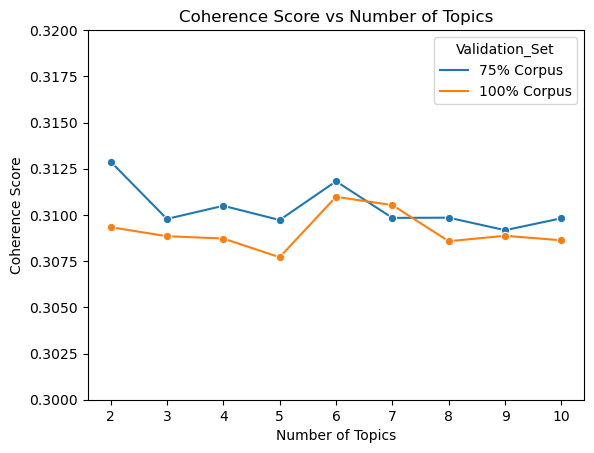

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Read the model_results from the CSV file
model_results_tfidf = pd.read_csv('lda_tuning_results_tfidf.csv')

# Plot the lines and remove the confidence interval
sns.lineplot(x='Topics', y='Coherence', hue='Validation_Set', data=model_results_tfidf, marker='o', errorbar=None)

# Set the labels and title
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs Number of Topics')
plt.ylim([0.3, 0.32])

# Display the graph
plt.show()

#### Selection of the optimum number of topics

In [8]:
# display the metrics and coherence score for the selected number of topics
num_topics_tfidf = 6

metrics_tfidf_df = model_results_tfidf[(model_results_tfidf['Topics'] == num_topics_tfidf) & (model_results_tfidf['Validation_Set'] == '100% Corpus')]
                           
metrics_tfidf_df = metrics_tfidf_df.sort_values('Coherence', ascending=False).head()   
metrics_tfidf_df

,Validation_Set,Topics,Alpha,Beta,Coherence
336,100% Corpus,6,0.31,0.01,0.317831
338,100% Corpus,6,0.31,0.61,0.315027
325,100% Corpus,6,symmetric,symmetric,0.314426
327,100% Corpus,6,symmetric,0.31,0.313683
328,100% Corpus,6,symmetric,0.61,0.313236


#### Selection of the optimum alpha and beta values

In [9]:
# select alpha and beta with the highest coherence value from the dataframe
alpha = metrics_tfidf_df.iloc[0,2]
beta = metrics_tfidf_df.iloc[0,3]

if alpha != 'symmetric':
    alpha = float(alpha)
if beta != 'symmetric':
    beta = float(beta)
    
print(alpha, beta)

# calculate the lda with the selected number of topics and parameters

best_lda_model_tfidf = gensim.models.LdaMulticore(corpus=tfidf_corpus,
                                           id2word=id2word,
                                           num_topics=num_topics_tfidf, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True,
                                           alpha=alpha,
                                           eta=beta)

0.31 0.01


#### Topics distribution across documents

In [10]:
import numpy as np

# column names
topicnames = ["Topic" + str(i) for i in range(1, best_lda_model_tfidf.num_topics + 1)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Create the document-topic matrix
document_topic_matrix_tfidf = np.zeros((len(df), best_lda_model_tfidf.num_topics))
for i, document in enumerate(tfidf_corpus):
    document_topic = best_lda_model_tfidf.get_document_topics(document)
    for topic, prob in document_topic:
        document_topic_matrix_tfidf[i][topic] = prob

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(document_topic_matrix_tfidf, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic + 1  # Add 1 to start with Topic Number 1

df_topic_distribution_tfidf = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution_tfidf.columns = ['Topic Num', 'Num Documents']
df_topic_distribution_tfidf

,Topic Num,Num Documents
0,4,4780
1,5,4090
2,1,3649
3,2,3123
4,6,2335
5,3,1429


#### Intertopic Distance Map

In [11]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings

# disable deprecation warning
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model_tfidf, tfidf_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.092279 -0.209145       1        1  18.895847
1      0.087031  0.125509       2        1  17.699967
0      0.066947  0.005499       3        1  17.587209
4      0.020218 -0.098023       4        1  17.361815
5      0.066573  0.171812       5        1  16.040059
2     -0.333047  0.004347       6        1  12.415103, topic_info=         Term        Freq       Total Category  logprob  loglift
95   mountain  312.000000  312.000000  Default  30.0000  30.0000
103     space  221.000000  221.000000  Default  29.0000  29.0000
454    pirate  174.000000  174.000000  Default  28.0000  28.0000
90      jones  171.000000  171.000000  Default  27.0000  27.0000
692      star  162.000000  162.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
287       big   79.305987  193.188042   Topic6  -5.0201   1.1959
110     world   86.263426  346.583015   Topic6  -4.9360   0.6955
266      show   80.801450  292.082788   Topic6  -5.0014   0.8012
69       also   71.201226  280.145244   Topic6  -5.1279   0.7165
82       fast   63.665328  340.588875   Topic6  -5.2397   0.4092

[451 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
651       1  0.991851     absolute
654       2  0.982649  accommodate
158       1  0.608593        adult
158       2  0.065794        adult
158       3  0.076760        adult
...     ...       ...          ...
23        1  0.811973        young
23        2  0.021182        young
23        4  0.155334        young
23        5  0.014121        young
1181      4  1.023430        yummy

[945 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 5, 6, 3])

![Inter-topic Distance Map](Topic_Distance_Maps/Intertopic_Map_LDA_TFIDF.jpg)

#### Top 10 Keywords for each Topic with Lambda = 1

In [12]:
# Show top 10 keywords for each topic
def show_topics(lda_model, n_words=20):
    topic_keywords = []
    for topic_weights in lda_model.get_topics():
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append([id2word[idx] for idx in top_keyword_locs])
    return topic_keywords

topic_keywords = show_topics(lda_model=best_lda_model_tfidf, n_words=10)        

# Topic-Keywords DataFrame
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i+1) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i+1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,not,park,ride,disney,line,disneyworld,day,only,hour,wait
Topic 2,member,cast,birthday,halloween,party,service,employee,not,people,special
Topic 3,mountain,space,pirate,jones,ride,star,indiana,tour,splash,car
Topic 4,place,kid,disneyland,disney,year,love,family,old,child,fun
Topic 5,great,day,christmas,time,line,pas,fast,busy,holiday,wait
Topic 6,hotel,food,water,eat,bring,get,walk,take,park,price


#### Adjustment of Lambda

In [13]:
lambd_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
all_topics = {}

for lambd in lambd_list:
    topics = {}
    for i in range(1, num_topics_tfidf+1):
        topic = vis.topic_info[vis.topic_info.Category == 'Topic'+str(i)].copy()
        topic['relevance'] = topic['loglift']*(1-lambd) + topic['logprob']*lambd
        topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).loc[:, 'Term'][:10].values
        
    all_topics['Lambda = ' + str(lambd)] = topics

df_all_topics_tfidf = pd.DataFrame(all_topics)
df_all_topics_tfidf.style.set_properties(**{'text-align': 'center'})

,Lambda = 0.0,Lambda = 0.2,Lambda = 0.4,Lambda = 0.6,Lambda = 0.8,Lambda = 1
Topic 1,['dream' 'detail' 'true' 'childhood' 'fabulous' 'heart' 'lifetime' 'joy' 'australia' 'history'],['life' 'memory' 'detail' 'dream' 'true' 'childhood' 'fabulous' 'girl' 'heart' 'original'],['place' 'life' 'earth' 'memory' 'age' 'magical' 'young' 'child' 'love' 'old'],['place' 'love' 'earth' 'child' 'old' 'kid' 'magical' 'age' 'family' 'life'],['place' 'kid' 'love' 'disneyland' 'old' 'year' 'child' 'family' 'earth' 'disney'],['place' 'kid' 'disneyland' 'disney' 'year' 'love' 'family' 'old' 'child' 'fun']
Topic 2,['cast' 'party' 'event' 'member' 'leg' 'celebrate' 'negative' 'customer' 'candy' 'turkey'],['member' 'cast' 'birthday' 'party' 'event' 'guest' 'customer' 'employee' 'anniversary' 'quality'],['member' 'cast' 'birthday' 'party' 'employee' 'guest' 'event' 'customer' 'halloween' 'service'],['member' 'cast' 'birthday' 'party' 'halloween' 'employee' 'service' 'guest' 'event' 'customer'],['member' 'cast' 'birthday' 'party' 'halloween' 'service' 'employee' 'guest' 'special' 'event'],['member' 'cast' 'birthday' 'halloween' 'party' 'service' 'employee' 'not' 'people' 'special']
Topic 3,['paris' 'universal' 'disappointment' 'waste' 'disappointing' 'maintenance' 'studio' 'february' 'spending' 'terrible'],['disneyworld' 'disappointed' 'paris' 'universal' 'disappointment' 'weekday' 'waste' 'disappointing' 'amount' 'maintenance'],['disneyworld' 'disappointed' 'orlando' 'paris' 'amount' 'weekday' 'however' 'florida' 'universal' 'queue'],['disneyworld' 'disappointed' 'orlando' 'not' 'queue' 'florida' 'however' 'only' 'hour' 'price'],['disneyworld' 'not' 'park' 'ride' 'disney' 'line' 'only' 'hour' 'queue' 'day'],['not' 'park' 'ride' 'disney' 'line' 'disneyworld' 'day' 'only' 'hour' 'wait']
Topic 4,['decoration' 'saturday' 'rain' 'grandson' 'thursday' 'blast' 'wednesday' 'mother' 'ariel' 'manageable'],['christmas' 'weather' 'holiday' 'decoration' 'perfect' 'weekend' 'super' 'saturday' 'busy' 'january'],['christmas' 'weather' 'holiday' 'weekend' 'busy' 'perfect' 'decoration' 'season' 'week' 'pas'],['christmas' 'holiday' 'busy' 'weather' 'great' 'pas' 'weekend' 'day' 'fast' 'perfect'],['christmas' 'great' 'day' 'pas' 'busy' 'time' 'holiday' 'line' 'fast' 'weather'],['great' 'day' 'christmas' 'time' 'line' 'pas' 'fast' 'busy' 'holiday' 'wait']
Topic 5,['bottle' 'december' 'shuttle' 'bus' 'march' 'fee' 'shopping' 'dont' 'thanksgiving' 'afford'],['hotel' 'water' 'snack' 'parking' 'downtown' 'bottle' 'december' 'shuttle' 'bus' 'discount'],['hotel' 'water' 'snack' 'parking' 'bring' 'downtown' 'eat' 'own' 'drink' 'bottle'],['hotel' 'water' 'eat' 'bring' 'snack' 'own' 'downtown' 'parking' 'food' 'drink'],['hotel' 'water' 'food' 'eat' 'bring' 'own' 'snack' 'walk' 'downtown' 'drink'],['hotel' 'food' 'water' 'eat' 'bring' 'get' 'walk' 'take' 'park' 'price']
Topic 6,['mountain' 'pirate' 'space' 'jones' 'indiana' 'tour' 'splash' 'caribbean' 'thunder' 'matterhorn'],['mountain' 'space' 'pirate' 'jones' 'star' 'indiana' 'tour' 'splash' 'caribbean' 'thunder'],['mountain' 'space' 'pirate' 'jones' 'star' 'indiana' 'tour' 'splash' 'caribbean' 'thunder'],['mountain' 'space' 'pirate' 'jones' 'star' 'indiana' 'tour' 'splash' 'mansion' 'caribbean'],['mountain' 'space' 'pirate' 'jones' 'star' 'indiana' 'tour' 'splash' 'ride' 'mansion'],['mountain' 'space' 'pirate' 'jones' 'ride' 'star' 'indiana' 'tour' 'splash' 'car']


### 4. Final Results

#### Top 15 words assigned to each topic with adjusted lambda

In [14]:
all_topics = {}
num_terms = 10  # Adjust number of words to represent each topic
lambd = 0.4  # Adjust this accordingly based on tuning above

for i in range(1, num_topics_tfidf + 1):
    topic = vis.topic_info[vis.topic_info.Category == 'Topic' + str(i)].copy()
    topic['relevance'] = topic['loglift'] * (1 - lambd) + topic['logprob'] * lambd
    top_words = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    all_topics['Topic ' + str(i)] = top_words

df_topics = pd.DataFrame(all_topics).T
df_topics.columns = ['word ' + str(i) for i in range(1, num_terms + 1)]

df_topics

,word 1,word 2,word 3,word 4,word 5,word 6,word 7,word 8,word 9,word 10
Topic 1,place,life,earth,memory,age,magical,young,child,love,old
Topic 2,member,cast,birthday,party,employee,guest,event,customer,halloween,service
Topic 3,disneyworld,disappointed,orlando,paris,amount,weekday,however,florida,universal,queue
Topic 4,christmas,weather,holiday,weekend,busy,perfect,decoration,season,week,pas
Topic 5,hotel,water,snack,parking,bring,downtown,eat,own,drink,bottle
Topic 6,mountain,space,pirate,jones,star,indiana,tour,splash,caribbean,thunder


#### Assignment of the reviews to the topics

In [15]:
# set columnwidth to maximum to see the whole review
pd.set_option('display.max_colwidth', None)

# reset index of dataframe for matching
df= df.reset_index(drop=True)
df_document_topic = df_document_topic.reset_index(drop=True)

# join the dataset with the document_topic dataframe based on indexes
df_joined = pd.merge(df, df_document_topic, left_index=True, right_index=True)
df_joined.head(10)

,Review_Text,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,dominant_topic
0,"this place has always been and forever will be special. the feeling you get entering the park, seeing the characters and different attractions is just priceless. this is definitely a dream trip for all ages, especially young kids. spend the money and go to disneyland, you will not regret it",0.06,0.05,0.05,0.66,0.06,0.12,4
1,"a great day of simple fun and thrills. bring cash, nothing is cheap, but we knew that it's disney. but they are great letting you bring in your own food, drinks, etc but read the list closely, we list several items at the entry gates (selfy sticks, glass refill bottles, etc). it is worth buying the photo pass and fastpass. have fun!",0.13,0.08,0.19,0.06,0.06,0.48,6
2,all and all a great day was had. the crowds are huge and ride times sometimes up to a 50 min wait but worth it. very disappointed the castle was under repair and covered but we understood. if you want to take a short cut on the rides grab a max pass for 15 each it allows you to book a time every 90mins and believe me it's a great feeling floating past the ques.,0.06,0.06,0.33,0.14,0.35,0.07,5
3,"having been to the florida location numerous times over the years i didn't know how this one would compare. the much smaller footprint made it quicker easier to get from ride to ride. the cinderella's castle was much much smaller, but also being renovated. many of the rides were identical, while some were notably different. the indiana jones ride (which fl does not have) was awesome. space mountain was much more puke worthy. it's a small world was way more beautiful from the exterior. they had several of the old rides that fl doesn't have (like pinocchio and mr. toad). i love how their fast passes worked... it was easy to use and we were able to use them back to back on rides, fast passing almost everything we wanted to ride. we went the first week of april and while crowded, i didn't think it was too bad. we were only in the park for like 7 hours and i do wish i'd had about 3 more hours to do everything.",0.28,0.04,0.21,0.16,0.14,0.17,1
4,"had the 4 day pass, spent 3 at dl and one at ca. great place to visit. we will be back. saw a lot in those days, but there is more that we missed, and more we want to see again.",0.07,0.22,0.07,0.08,0.49,0.07,5
5,oh my god you can really forget your self and enjoy everything you face there its a huge word of fun,0.07,0.07,0.07,0.32,0.07,0.39,6
6,"we were so sad that the castle was under refurbishment, but we didn t let it ruin our good time. i purchased the maxpass before we went and it was super easy to use and very convenient. maxpass includes free pictures taken by disney photographers. i have been to disney world and there is no shortage of photographers. this was not the case here. they definitely need to add more. we were able to do all of the rides that we wanted to do, and we got the snacks that we wanted to try. we spent two days here and on the last day we watched the fireworks show. it was amazing. all of the workers were polite and helpful.",0.31,0.07,0.05,0.05,0.39,0.14,5
7,"took my son to the park on a weekend(fri sun). very busy all over the places. my son enjoyed it, but he was very sad that he could not try a lot of attractions as the wait time was huge.....( ranging from 60 90 minutes) if you have a lot of time to waste waiting in the line for the attractions, fastpass system at the park is just a ripoff. you can have only one attraction added to your plan at any point, once you complete that attraction you can add one more.",0.59,0.05,0.05,0.06,0.20,0.05,1
8,"there's nothing like disneyland and it should be on your bucket list if you've never been. park is well maintained and parking is ok, but not cheap at $25. tickets can cost up to $150 per adult (10 years old and up) during peak periods. food is not cheap either. if you take a family without a season's pass, you could easily spend hundreds of dollars just on admission ti